# Politics

- Data Cleaning
- Data Visualisation
- Data Analysis

In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from datetime import datetime
from datetime import timezone
from SPARQLWrapper import SPARQLWrapper, JSON

%matplotlib inline

In [2]:
# Reading the data from politics revisions
# Contains the revisions for all the selected items
revisions = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/politics_revisions.csv')
items = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data/politics.csv')

In [3]:
print("Number of Revisions in Politics Dataset")
print(revisions.shape)
print("Number of Wikidata Items in Politics Dataset")
print(items.shape)

Number of Revisions in Politics Dataset
(3915164, 12)
Number of Wikidata Items in Politics Dataset
(414463, 3)


# Data Cleaning

- Drop uneccessary columns
- Assign types for all edits
- Assign user types for all edits
- Remove rows with empty comments - better to remove after calculating the types in case there are some edge cases which have not been discovered
- Convert timestamps to datetime objects
- (Remove items that contain only bot edits)
- Remove items with editcounts < (If removing rows with empty comments will need to recalculate the edit count and merge with dataset)

In [4]:
# Dropping unecessary columns from the revisions dataframe
rev = revisions.drop(['pageid', 'type', 'editentity', 'parentid'], axis=1)

In [5]:
# Method to assign edit types to each revision by using the comment
def get_edit_type(comment):
    # Decoding the comment from a bytes object to a string
    # Converting the comment to lowercase
    # c = comment.decode("utf-8").lower()
    c = comment.lower()
    # print(c)
    editType = '' 
    
    if c == '':
        return editType
    
    if "|" in c:
        # Comments which have |
        cc = c.split("|")[0].replace("/* ", "")
        if 'undo' in cc:
            editType = 'undo'
            return editType
        elif 'restore' in cc:
            editType = 'restore'
            return editType
        elif 'wbsetclaimvalue' in cc:
            editType = 'set'
            return editType
        elif 'wbsetlabeldescriptionaliases' in cc:
            editType = 'set'
            return editType
        elif 'wbcreateredirect' in cc:
            editType = 'create'
            return editType
        elif 'merge' in cc:
            editType = 'merge'
            return editType
        elif '-' in cc:
            ccc = cc.split("-")[1]
            if 'create' in ccc:
                editType = 'create'
                return editType
            elif 'add' in ccc:
                editType = 'add'
                return editType
            elif 'set' in ccc:
                editType = 'set'
                return editType
            elif 'update' in ccc:
                editType = 'update'
                return editType
            elif 'remove' in ccc:
                editType = 'remove'
                return editType
    if 'revert' in c: 
        editType = 'revert'
        return editType  
    elif 'protect' in c:
        editType = 'protect'
        return editType  
    elif 'undid' in c:
        editType = 'undo'
        return editType      
    return editType
        

In [6]:
# Assigning edit types to each revision
rev['type'] = [get_edit_type(comment) for comment in rev['comment']]

In [7]:
rev.shape

(3915164, 9)

In [8]:
# Removing revisions with empty types 
# Removing revisions that either had an empty comment or or an edge case
to_remove = rev[rev['type'] == ''].index
rev = rev.drop(to_remove)

In [9]:
# Reading csv with bot names scraped from Wikidata
bots = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/wikidata_bots.csv')

In [10]:
# Method to assign user types to revisions
# 3 types: Registered, Anonymous, Bot
def get_user_type(user):
    
    u = user[1:].replace("'", "")
    
    userType = ''
    
    if u == "":
        userType = 'Anonymous'
        return userType
    elif u in bots.values:
        userType = 'Bot'
        return userType
    else: 
        userType = 'Registered'
        return userType
    return userType
    

In [11]:
# Assigning user types to revisions
rev['usertype'] = [get_user_type(user) for user in rev['username']]

In [12]:
# Need to recalculate editcount for the items
# Drop old editcount column
rev = rev.drop(['editscount'], axis=1)

In [13]:
editscount = rev['qid'].value_counts()

In [14]:
editscount.describe()

count    413848.000000
mean          9.417475
std          17.753846
min           1.000000
25%           2.000000
50%           3.000000
75%           8.000000
max        1431.000000
Name: qid, dtype: float64

Rationale for Removing edits <= 5

- Research
- Range of edits is very large
- Median value that is the 50th percentile is 3 edits that is more than half the dataset has items that would not be very interesting to the research as we are interested in highly edited items
- Items in the 75th percentile have an editcount of 8 showing that only a small percentage of items - slightly greater than 25% of the items are those that can be deemed interesting
- Also important to note that given these values, the data could also contain a reasonable number of outliers - items which are highly edited but do not add value to the research - for example they do not contain reverts or they are sandbox items

In [15]:
# Converting to a dataframe so that it can be compared/merged with original dataframe
df_editscount = pd.DataFrame({'qid':editscount.index, 'editscount':editscount.values})

In [16]:
print('Items with No of Edits = 1')
print(len(df_editscount[df_editscount['editscount'] == 1]))

print('Items with No of Edits = 2')
print(len(df_editscount[df_editscount['editscount'] == 2]))

print('Items with No of Edits = 3')
print(len(df_editscount[df_editscount['editscount'] == 3]))

print('Items with No of Edits = 4')
print(len(df_editscount[df_editscount['editscount'] == 4]))

print('Items with No of Edits = 5')
print(len(df_editscount[df_editscount['editscount'] == 5]))

print('Items with No of Edits <= 5')
print(len(df_editscount[df_editscount['editscount'] <= 5]))

Items with No of Edits = 1
100579
Items with No of Edits = 2
75742
Items with No of Edits = 3
40352
Items with No of Edits = 4
32317
Items with No of Edits = 5
22804
Items with No of Edits <= 5
271794


In [17]:
# Removing items with editscount <= 5 
to_remove = df_editscount[df_editscount['editscount'] <= 5].index
df_editscount = df_editscount.drop(to_remove)

In [18]:
df_editscount.shape

(142054, 2)

In [19]:
# Removing all items with editscount <= 5 from revisions dataset
# Removing by finding intersection on qid between both sets
rev = pd.merge(rev, df_editscount, how='inner', on=['qid'])

In [20]:
# Converting the timestamps to datetime object
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

# Converting to datetime leaves the dates in form '2016-10-12 14:37:53+00:00'
# Formatting timestamp to remove +00:00
rev['timestamp'] = rev['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# strftime() returns a string object
# Converting back to datetime
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

In [21]:
# To query info based on datetime remember to input dates in complete formatting
# rev[rev['timestamp'] >= '2016-10-01 00:00:00']

Imp to parse timestamps as you would potentially be interested in looking at the time difference between edits in the future, difference between datetime objects can be found using timedelta from datetime.

In [22]:
rev.dtypes

Unnamed: 0             int64
qid                   object
revisionid           float64
timestamp     datetime64[ns]
comment               object
userid               float64
username              object
type                  object
usertype              object
editscount             int64
dtype: object

In [23]:
# Sparql Query to get labels using Qids
def get_item_label(qid):
    try:        
        # Specifying the Wikidata SPARQL endpoint
        sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
        
        # Query to access the label for the wikidata item
        sparql.setQuery('PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> SELECT ?label WHERE {wd:' + qid + ' rdfs:label ?label . SERVICE wikibase:label { bd:serviceParam wikibase:language "en". } } LIMIT 1')
        
        # Converting result to JSON format
        sparql.setReturnFormat(JSON)
        result = sparql.query().convert()
        
        # result is in the form of "bindings" which are a list of dictionaries
        # Accessing the value of the label 
        itemLabel = result["results"]["bindings"][0]["label"]["value"]
        
        return itemLabel
    except Exception as ex:
        print(ex)
        return('')

In [24]:
print(df_editscount.head())
# Discovered sandbox item within data with editscount = 1431
print(get_item_label('Q4115189'))

        qid  editscount
0  Q4115189        1431
1  Q3642765         917
2  Q3964154         743
3  Q4504204         726
4   Q534197         702
Викиданные:Песочница


In [30]:
# Removing sandbox item from editscount and rev
to_remove = df_editscount[df_editscount['qid'] == 'Q4115189'].index
df_editscount = df_editscount.drop(to_remove)
# Removing item from dataset of revisions
to_remove_from_rev = rev[rev['qid'] == 'Q4115189'].index
rev = rev.drop(to_remove_from_rev)

In [27]:
# Removing wikipedia item from editscount and rev
to_remove = df_editscount[df_editscount['qid'] == 'Q52'].index
df_editscount = df_editscount.drop(to_remove)
# Removing item from dataset of revisions
to_remove_from_rev = rev[rev['qid'] == 'Q52'].index
rev = rev.drop(to_remove_from_rev)

In [28]:
# Removing wikidata item from editscount and rev
to_remove = df_editscount[df_editscount['qid'] == 'Q2013'].index
df_editscount = df_editscount.drop(to_remove)
# Removing item from dataset of revisions
to_remove_from_rev = rev[rev['qid'] == 'Q2013'].index
rev = rev.drop(to_remove_from_rev)

In [31]:
print(df_editscount.head())
print(rev[rev['qid'] == 'Q4115189'])
print(rev[rev['qid'] == 'Q52'])
print(rev[rev['qid'] == 'Q2013'])

        qid  editscount
1  Q3642765         917
2  Q3964154         743
3  Q4504204         726
4   Q534197         702
5     Q1085         657
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []


# Descriptive Statistics

In [32]:
rev['editscount'].describe().astype(int)

count    3279348
mean          49
std           49
min            6
25%           16
50%           63
75%           65
max          917
Name: editscount, dtype: int32

In [33]:
rev['type'].describe()

count     3279348
unique         10
top           add
freq      2606406
Name: type, dtype: object

In [34]:
# TODO: Calculate number of items in different ranges and plot in bar chart

In [35]:
politics_items = rev['qid'].value_counts()

In [37]:
# converting a series to a dataframe
p_items = pd.DataFrame({'type':politics_items.index, 'count':politics_items.values})

In [38]:
# Items between the median and 75th percentile
p_items[(p_items['count'] >= 63) & (p_items['count'] <= 65)]

,type,count
9432,Q929575,65
9433,Q615282,65
9434,Q1164359,65
9435,Q630323,65
9436,Q593131,65
...,...,...
23981,Q632428,63
23982,Q584038,63
23983,Q217218,63
23984,Q395585,63


# Statistics for Proxies

In [39]:
# Counting the value of the number of proxies that exist in the dataset
type_stats = rev['type'].value_counts()

In [40]:
# Converting a series to a Dataframe
type_s = pd.DataFrame({'type':type_stats.index, 'count':type_stats.values})
ts = type_s.set_index('type')
print(ts)

           count
type            
add      2606406
create    381588
update    195546
remove     63989
set        28448
undo        1062
revert      1028
merge        850
restore      407
protect       24


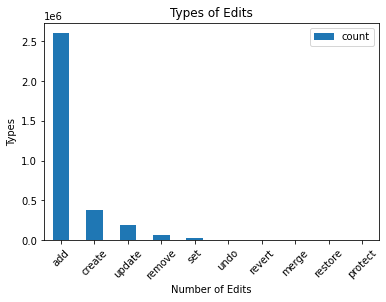

In [41]:
# Plotting the statistics for the proxies/types of edits in the data
ax = ts.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

plt.show()

According to the bar plot the proxy with the highest occurrence is add followed by create, update, remove, set and those with no types specified (those without any comments). 

This was expected behaviour as this infers that editors are adding a lot of information to wikidata over a period of time. As we are exploring controversies in wikidata, the remaining edits namely - reverts, undos, removes, merges, restores and protect will be more useful thus we will visualise those.

In [42]:
# Extracting select proxies: remove, restore, revert, merge, undo, protect
controversial_proxies = ts.iloc[[3, 5, 6, 7, 8, 9]]
# print(controversial_proxies)

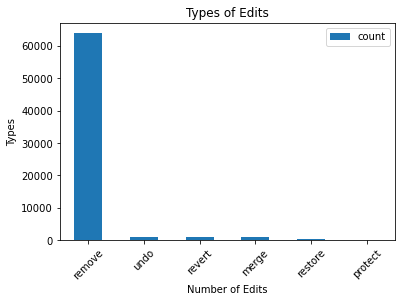

In [43]:
# Plotting select proxies
ax = controversial_proxies.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

# ax.invert_yaxis()

plt.show()

Remove is very high as compared to the others to better understand them, let's plot these reverts itself [Can remove later]

In [44]:
# Extracting select proxies: restore, revert, merge, undo, protect
controversial_proxies_without_remove = ts.iloc[[5, 6, 7, 8, 9]]
print(controversial_proxies_without_remove)

         count
type          
undo      1062
revert    1028
merge      850
restore    407
protect     24


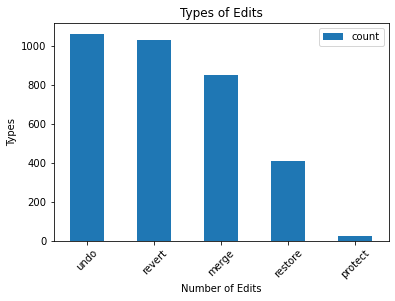

In [45]:
# Plotting select proxies without remove
ax = controversial_proxies_without_remove.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

# ax.invert_yaxis()

plt.show()

Interesting to observe that the number of undos is greater that reverts. What could be the reason for this? What could be the potential impact? Could we consider undos as important as reverts? Undoing an edit, reverting to a previous edit. What value do they hold?

# Statistics for No of Edits

In [46]:
# # Plotting No of Edits for the Items in the dataset 
# # Scatter Plot

# plt.scatter(politics_items.index, politics_items.values)

# plt.title("No of Edits vs No of Items")
# plt.xlabel("Number of Items")
# plt.ylabel("No of Edits")

# plt.show()

In [47]:
no_of_edits = politics_items.to_numpy()

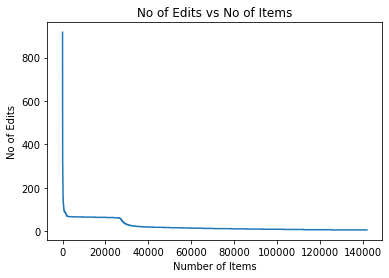

In [48]:
# Plotting No of Edits for the Items in the dataset 
# Line Plot

plt.plot(no_of_edits)

plt.title("No of Edits vs No of Items")
plt.xlabel("Number of Items")
plt.ylabel("No of Edits")

plt.show()

Very few items have a high number of edits as compared to the rest of the dataset.

# Grouping by Proxies

In [58]:
reverts = rev["type"].str.contains("revert")
revert_edits = reverts.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [53]:
merges = rev["type"].str.contains("merge")
merge_edits = merges.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [54]:
undos = rev["type"].str.contains("undo")
undo_edits = undos.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [55]:
restores = rev["type"].str.contains("restore")
restore_edits = restores.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [56]:
protects = rev["type"].str.contains("protect")
protect_edits = protects.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [57]:
removes = rev["type"].str.contains("remove")
remove_edits = removes.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [59]:
# Creating a dataframe which will contain qids for items and no of each proxy
proxies = pd.DataFrame({'revert': revert_edits, 'merge': merge_edits, 'undo': undo_edits, 'restore': restore_edits, 
                        'protect': protect_edits, 'remove': remove_edits})

In [60]:
proxies = proxies.reset_index()

In [61]:
proxies.columns

Index(['qid', 'revert', 'merge', 'undo', 'restore', 'protect', 'remove'], dtype='object')

In [62]:
df_editscount.columns

Index(['qid', 'editscount'], dtype='object')

In [63]:
# Adding editscount for each item 
proxies = pd.merge(proxies, df_editscount, how='inner', on=['qid'])

In [64]:
# Counting the number of users per item that is userscount
rev_users = rev.groupby('qid')['username'].nunique()
# Converting to a dataframe so that it can be compared/merged 
df_userscount = pd.DataFrame({'qid':rev_users.index, 'userscount':rev_users.values})

In [65]:
# Adding userscount for each item 
proxies = pd.merge(proxies, df_userscount, how='inner', on=['qid'])

In [66]:
proxies.describe()

,revert,merge,undo,restore,protect,remove,editscount,userscount
count,142051.000000,142051.000000,142051.000000,142051.000000,142051.000000,142051.000000,142051.000000,142051.000000
mean,0.007237,0.005984,0.007476,0.002865,0.000169,0.450465,23.085709,2.569781
std,0.139758,0.081732,0.131438,0.071875,0.012997,1.499924,24.821218,1.840124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,2.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,3.000000
max,15.000000,4.000000,19.000000,8.000000,1.000000,137.000000,917.000000,122.000000


Observations:
- Proxies do not exist for a lot of items
- Mean is very low
- Median is 0 for all proxies, 75th percentile is also 0
- Remove has the highest value in the dataset, followed by undo, revert, restore, merge, protected
- Dataset has shown that it contains a high number remove edits however assumptions that reverts an undo would be useful can be deemed true as the dataset contains more of them
- New Assumption: revert, undo, restore will be most useful to look at

Text(0, 0.5, 'No of Edits')

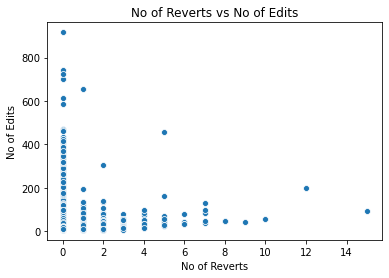

In [67]:
ax = sns.scatterplot(x="revert", y="editscount", data=proxies)
ax.set_title("No of Reverts vs No of Edits")
ax.set_xlabel("No of Reverts")
ax.set_ylabel("No of Edits")
# No of reverts are very low for highly edited items

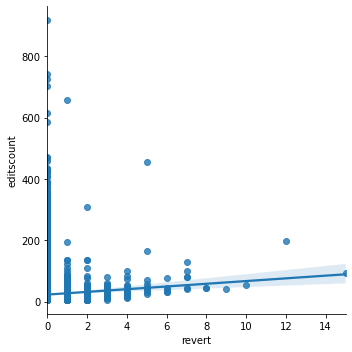

In [68]:
sns.lmplot(x="revert", y="editscount", data=proxies)

In [69]:
corr_matrix = proxies.corr()
corr_matrix
# merge and editscount have a negative correlation

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,0.046129,0.343112,0.433843,0.344251,0.053561,0.024845,0.273225
merge,0.046129,1.000000,0.058745,0.059396,0.025556,0.039227,-0.023985,0.099592
undo,0.343112,0.058745,1.000000,0.277173,0.184700,0.069153,0.034572,0.301307
restore,0.433843,0.059396,0.277173,1.000000,0.233093,0.087414,0.035755,0.215469
protect,0.344251,0.025556,0.184700,0.233093,1.000000,0.013068,0.011019,0.085457
remove,0.053561,0.039227,0.069153,0.087414,0.013068,1.000000,0.190161,0.032988
editscount,0.024845,-0.023985,0.034572,0.035755,0.011019,0.190161,1.000000,-0.135133
userscount,0.273225,0.099592,0.301307,0.215469,0.085457,0.032988,-0.135133,1.000000


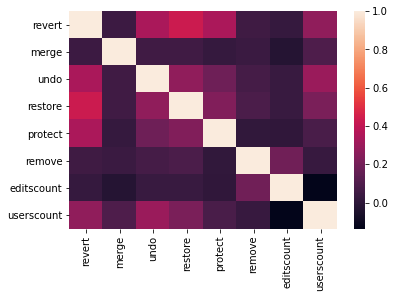

In [70]:
sns.heatmap(corr_matrix)

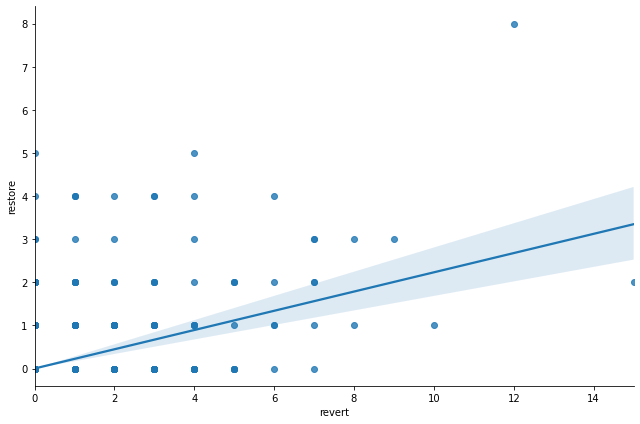

In [71]:
# restore and revert have some correlation - weak positive
sns.lmplot(x="revert", y="restore", data=proxies, height=6, aspect=1.5)

Text(0, 0.5, 'No of Edits')

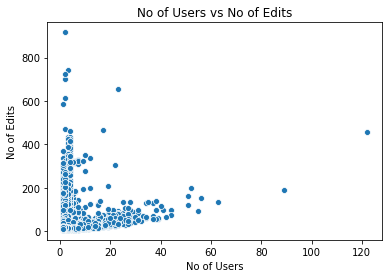

In [72]:
# userscount and editscount have a weak negative correlation - although not very high - it is much higher than others
ax = sns.scatterplot(x="userscount", y="editscount", data=proxies)
ax.set_title("No of Users vs No of Edits")
ax.set_xlabel("No of Users")
ax.set_ylabel("No of Edits")

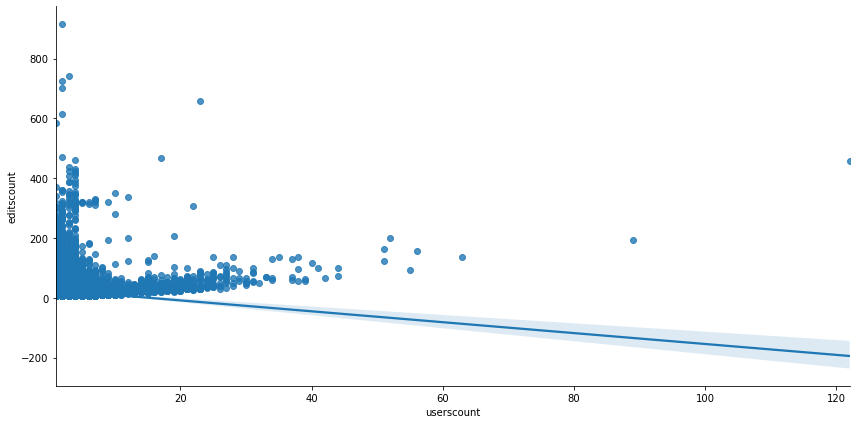

In [73]:
sns.lmplot(x="userscount", y="editscount", data=proxies, height=6, aspect=2)

In [74]:
# (proxies[proxies['userscount'] == 1]).to_csv('/Users/tushi/PRJ/WikidataParsing/test_user_1.csv')

In [75]:
# Removing items with 0 reverts, merges, undos, restores, removes, protects
# Removing items with editscount <= 5 
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0) & 
                   (proxies['remove'] == 0) & (proxies['protect'] == 0)].index
proxies = proxies.drop(to_remove)

In [76]:
# proxies.to_csv('/Users/tushi/PRJ/WikidataParsing/test_proxies.csv')

In [77]:
proxies.shape

(22100, 9)

In [78]:
# Observation - lots of items which only have a remove edit and no other
# Expected as remove dominates the controversial proxies by almost 63000 edits
# What happens if we remove the items which only have a remove edit?
# Disregarding protect since it has very few values - protect is there to see its presence in controversial items we chose
proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)]

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
7,Q2124963,0,0,0,0,0,5,10,1
8,Q2125493,0,0,0,0,0,1,9,4
10,Q2126280,0,0,0,0,0,1,6,3
11,Q2126516,0,0,0,0,0,8,42,3
102,Q2129957,0,0,0,0,0,1,10,4
...,...,...,...,...,...,...,...,...,...
141716,Q28064887,0,0,0,0,0,1,9,3
141759,Q28065753,0,0,0,0,0,1,19,2
141899,Q28086637,0,0,0,0,0,1,21,1
141919,Q28090273,0,0,0,0,0,3,40,1


In [79]:
# Out of a dataset of 22102, 19849 rows do not have edits under revert, merge, undo, restore
proxies.nlargest(10, 'remove')

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
8408,Q1085,1,0,0,1,0,137,657,23
9328,Q9903,0,0,2,0,0,95,208,19
83624,Q272471,0,0,0,1,0,80,84,4
8087,Q35,0,1,2,1,0,74,129,34
9724,Q14960,0,0,1,0,0,59,279,10
9130,Q8385,1,0,0,4,0,38,195,9
4111,Q2503488,0,0,0,0,0,37,38,1
19160,Q146307,0,0,0,0,0,35,179,6
86558,Q368888,0,0,0,0,0,35,184,6
19163,Q146351,0,0,0,0,0,33,165,4


In [80]:
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)].index
proxies_without_remove = proxies.drop(to_remove)

In [81]:
corr = proxies_without_remove.corr()
corr

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,-0.253887,0.196290,0.352643,0.333038,0.070283,0.254487,0.366865
merge,-0.253887,1.000000,-0.273769,-0.157151,-0.041294,0.002516,-0.106448,-0.170772
undo,0.196290,-0.273769,1.000000,0.160671,0.156071,0.106884,0.342741,0.414393
restore,0.352643,-0.157151,0.160671,1.000000,0.212743,0.170188,0.311490,0.283143
protect,0.333038,-0.041294,0.156071,0.212743,1.000000,0.015270,0.092415,0.120778
remove,0.070283,0.002516,0.106884,0.170188,0.015270,1.000000,0.628021,0.213715
editscount,0.254487,-0.106448,0.342741,0.311490,0.092415,0.628021,1.000000,0.610786
userscount,0.366865,-0.170772,0.414393,0.283143,0.120778,0.213715,0.610786,1.000000


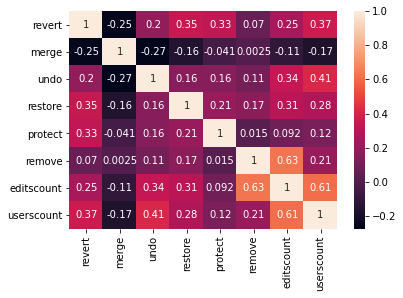

In [82]:
sns.heatmap(corr, annot=True)
# TODO: Evaluate this correlation heatmap

In [83]:
proxies_without_remove.to_csv('/Users/tushi/PRJ/WikidataParsing/topics/proxies/politics.csv')

- Top 20 Reverts, Merges...
- Edits vs Users (Either do correlation or something else)

# Top 20 Reverts

In [84]:
top20_reverts = proxies_without_remove.nlargest(20, 'revert')

In [85]:
top20_reverts

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
8209,Q517,15,1,5,2,1,12,95,27
8972,Q6294,12,0,3,8,0,14,199,52
8084,Q23,10,0,1,1,0,8,55,15
9756,Q15975,9,1,1,3,1,0,41,13
79415,Q182276,8,0,6,1,1,3,45,13
84455,Q296741,8,0,1,3,1,0,46,9
8080,Q29,7,0,8,3,0,5,130,37
8106,Q77,7,0,2,2,0,0,82,23
8113,Q96,7,0,4,1,0,4,82,31
8296,Q801,7,0,3,2,0,6,99,28


In [86]:
revert_item_labels = ['Napoleon', 'Hillary Clinton', 'George Washington', 'Montesquieu', 'Benito Juárez',
                     'Enrique Peña Nieto', 'Spain', 'Uruguay', 'Mexico', 'Israel', 
                     'Bill Clinton', 'Karl Marx', 'Michelle Bachelet', 'Mahatma Gandhi', 'Che Guevara', 
                     'Ronaldinho', 'Maximilien Robespierre', 'Chile', 'Julius Caesar', 'Dante Alighieri']

In [87]:
# Inserting item labels into revert proxies dataframe
top20_reverts.insert(1, "label", revert_item_labels, True)

In [88]:
top20_reverts

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
8209,Q517,Napoleon,15,1,5,2,1,12,95,27
8972,Q6294,Hillary Clinton,12,0,3,8,0,14,199,52
8084,Q23,George Washington,10,0,1,1,0,8,55,15
9756,Q15975,Montesquieu,9,1,1,3,1,0,41,13
79415,Q182276,Benito Juárez,8,0,6,1,1,3,45,13
84455,Q296741,Enrique Peña Nieto,8,0,1,3,1,0,46,9
8080,Q29,Spain,7,0,8,3,0,5,130,37
8106,Q77,Uruguay,7,0,2,2,0,0,82,23
8113,Q96,Mexico,7,0,4,1,0,4,82,31
8296,Q801,Israel,7,0,3,2,0,6,99,28


In [109]:
# Can remove the enumerated values on top of the bars

Text(0.5, 1.0, 'Top 20 Items with Highest Reverts')

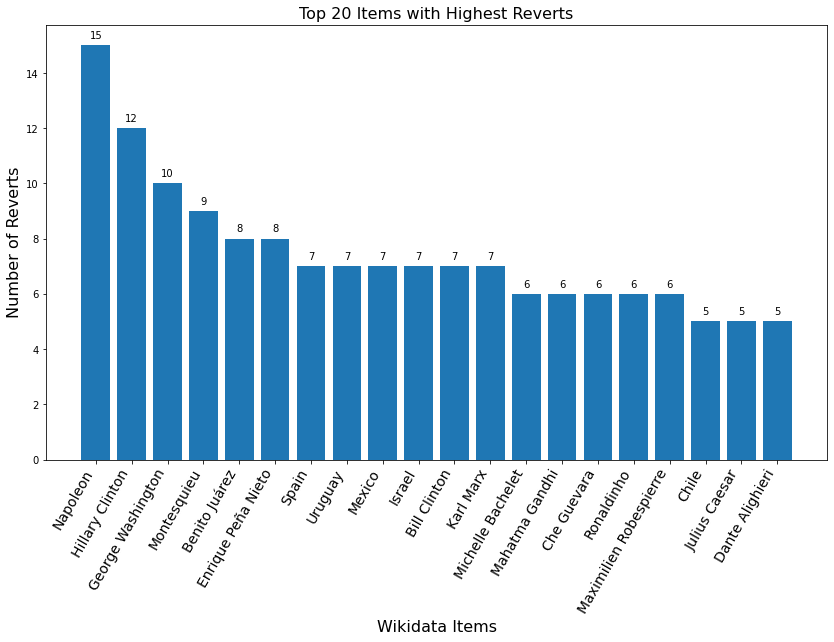

In [129]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_reverts['revert']):
    ax.text(i, r+0.25, str(r), horizontalalignment='center')

plt.bar(top20_reverts['label'], top20_reverts['revert'])
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Reverts", fontsize=16)
plt.title("Top 20 Items with Highest Reverts", fontsize=16)

In [151]:
top20_merges = proxies_without_remove.nlargest(20, 'merge')

In [152]:
top20_merges

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
64481,Q13202722,0,4,0,0,0,0,10,4
136611,Q20571352,0,4,0,1,0,2,13,5
76318,Q25945398,0,3,0,0,0,0,6,3
136610,Q20571325,0,3,0,0,0,2,9,4
4806,Q2550468,0,2,0,0,0,2,11,2
6266,Q2604568,1,2,0,0,0,0,6,3
8610,Q1865,0,2,0,0,0,0,26,19
12602,Q53880,0,2,0,0,0,0,6,3
12841,Q57553,3,2,1,0,0,1,21,11
13411,Q64224,0,2,0,0,0,2,12,6


In [153]:
merge_item_labels = ['permanent duplicate item-France', 'permanent duplicate item-Turkey', 'template-Internet Movie Database', 'permanent duplicate item-USA', 'Nicolás Ruiz',
                     'Nagarote', 'Kuala Lumpur', 'Firmo', 'Mohammed VI', 'Opfikon', 
                     'Markus Welser', 'Frymburk', 'Allyene', 'template-Page Name Base', 'Quiriego', 
                     'permanent duplicate item-Pyotr Ilyich Tchaikovsky', 'wikimedia category', 'permanent duplicate item-Austria', 'permanent duplicate item-Societ Union', 'permanent duplicate item-Jesus']

# Inserting item labels into merge proxies dataframe
top20_merges.insert(1, "label", merge_item_labels, True)

In [154]:
top20_merges

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
64481,Q13202722,permanent duplicate item-France,0,4,0,0,0,0,10,4
136611,Q20571352,permanent duplicate item-Turkey,0,4,0,1,0,2,13,5
76318,Q25945398,template-Internet Movie Database,0,3,0,0,0,0,6,3
136610,Q20571325,permanent duplicate item-USA,0,3,0,0,0,2,9,4
4806,Q2550468,Nicolás Ruiz,0,2,0,0,0,2,11,2
6266,Q2604568,Nagarote,1,2,0,0,0,0,6,3
8610,Q1865,Kuala Lumpur,0,2,0,0,0,0,26,19
12602,Q53880,Firmo,0,2,0,0,0,0,6,3
12841,Q57553,Mohammed VI,3,2,1,0,0,1,21,11
13411,Q64224,Opfikon,0,2,0,0,0,2,12,6


Text(0.5, 1.0, 'Top 20 Items with Highest Merges')

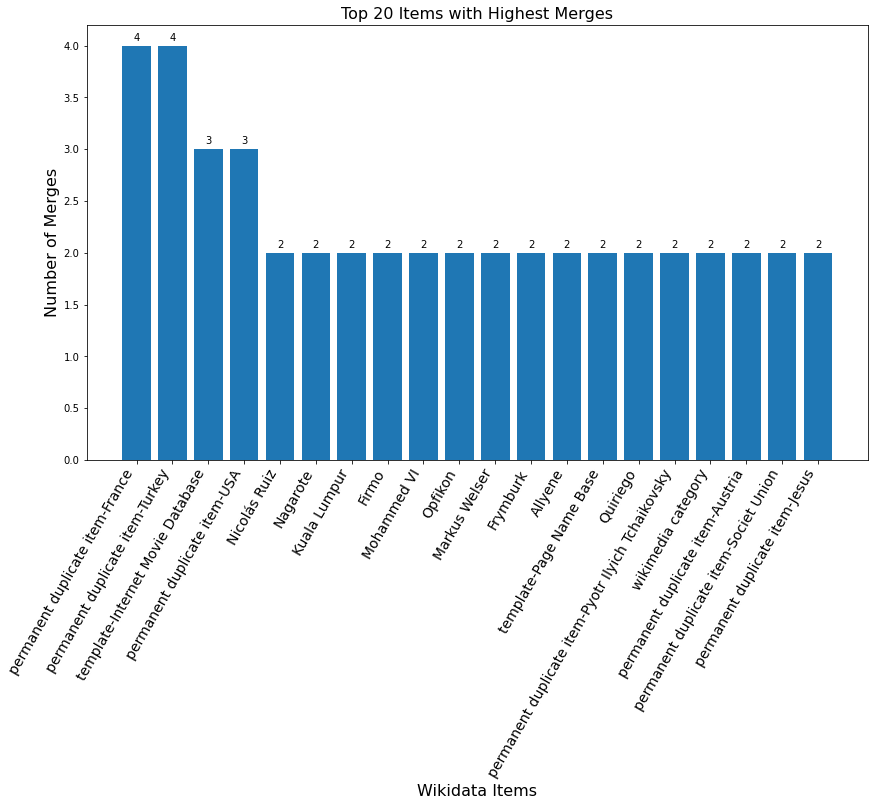

In [155]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_merges['merge']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

plt.bar(top20_merges['label'], top20_merges['merge'])
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Merges", fontsize=16)
plt.title("Top 20 Items with Highest Merges", fontsize=16)

In [156]:
top20_undos = proxies_without_remove.nlargest(20, 'undo')

In [157]:
top20_undos

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
11055,Q22686,5,1,19,2,0,28,456,122
9434,Q11256,5,1,16,0,0,7,164,51
88131,Q433210,1,0,11,1,1,10,109,27
8080,Q29,7,0,8,3,0,5,130,37
8081,Q30,1,1,6,4,1,5,122,51
12665,Q54898,0,0,6,0,0,0,15,4
12726,Q56226,1,0,6,1,0,1,71,15
79415,Q182276,8,0,6,1,1,3,45,13
8127,Q183,0,0,5,0,0,14,115,40
8209,Q517,15,1,5,2,1,12,95,27


In [158]:
undo_item_labels = ['Donald Trump', 'Fidel Castro', 'Rita Barberá Nolla', 'Spain', 'United States of America',
                     'San Cristóbal de La Laguna', 'Kim Jong-un', 'Benito Juárez', 'Germany', 'Napoleon', 
                     'Mahatma Gandhi', 'Muhammad', 'Abraham Cahan', 'no label', 'Mexico', 
                     'Monaco', 'Venezuela', 'Madrid', 'Vladimir Putin', 'Schwyz']

# Inserting item labels into undo proxies dataframe
top20_undos.insert(1, "label", undo_item_labels, True)

Text(0.5, 1.0, 'Top 20 Items with Highest Undos')

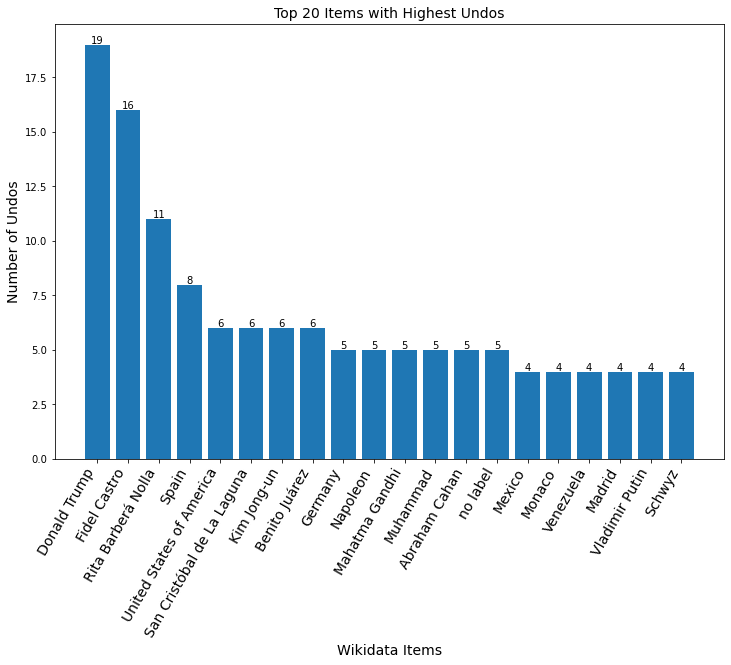

In [160]:
f, ax = plt.subplots(figsize=(12,8))

for i, r in enumerate(top20_undos['undo']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

plt.bar(top20_undos['label'], top20_undos['undo'])
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=14)
plt.ylabel("Number of Undos", fontsize=14)
plt.title("Top 20 Items with Highest Undos", fontsize=14)

In [161]:
top20_restores = proxies_without_remove.nlargest(20, 'restore')

In [162]:
top20_restores

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
8972,Q6294,12,0,3,8,0,14,199,52
7075,Q2668161,0,0,0,5,0,13,61,5
11455,Q29179,4,0,2,5,0,3,53,18
8081,Q30,1,1,6,4,1,5,122,51
8195,Q414,3,0,0,4,0,3,80,24
8253,Q717,4,0,4,4,0,2,85,27
8368,Q1001,6,0,5,4,0,1,78,27
9104,Q7747,2,0,4,4,0,12,307,22
9130,Q8385,1,0,0,4,0,38,195,9
9139,Q8605,3,0,0,4,0,4,38,14


In [163]:
restore_item_labels = ['Hillary Clinton', 'John Hagelin', 'Francisco Franco', 'United States of America', 'Argentina',
                     'Venezuela', 'Mahatma Gandhi', 'Vladimir Putin', 'Ostrava', 'Simón Bolívar ', 
                     'Mario Benedetti', 'Miguel López de Legazpi', 'Spain', 'Barack Obama', 'Vladimir Lenin', 
                     'Nelson Mandela', 'Karl Marx', 'Montesquieu', 'no label', 'Enrique Peña Nieto']

# Inserting item labels into restore proxies dataframe
top20_restores.insert(1, "label", restore_item_labels, True)

Text(0.5, 1.0, 'Top 20 Items with Highest Restores')

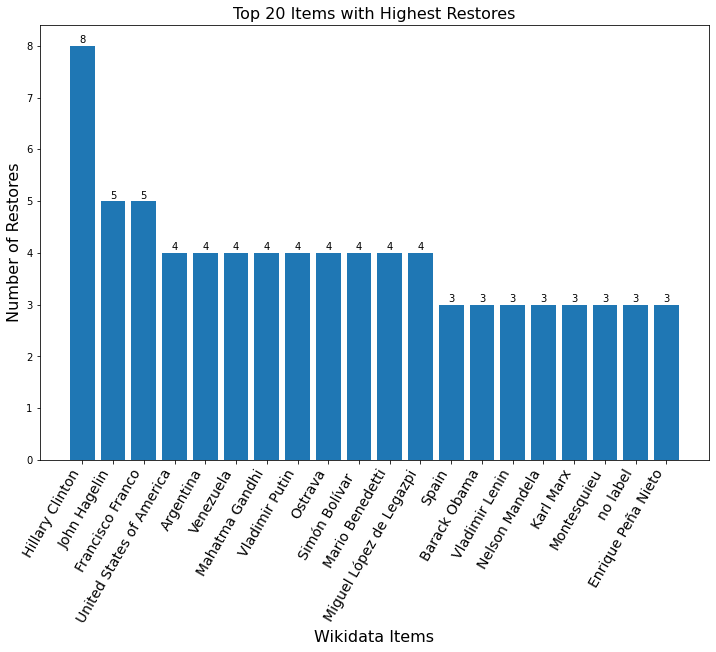

In [164]:
f, ax = plt.subplots(figsize=(12,8))

for i, r in enumerate(top20_restores['restore']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

plt.bar(top20_restores['label'], top20_restores['restore'])
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Restores", fontsize=16)
plt.title("Top 20 Items with Highest Restores", fontsize=16)

In [178]:
top20_protects = proxies_without_remove.nlargest(20, 'protect')

In [179]:
top20_protects

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
8081,Q30,1,1,6,4,1,5,122,51
8122,Q155,1,0,1,0,1,1,71,25
8209,Q517,15,1,5,2,1,12,95,27
8292,Q796,2,0,2,0,1,3,78,19
8301,Q811,2,0,0,1,1,1,60,17
8398,Q1048,5,0,0,2,1,6,42,19
8492,Q1399,5,1,0,0,1,0,25,12
8694,Q2685,5,0,2,0,1,2,39,14
9121,Q8027,2,0,0,0,1,0,42,14
9199,Q9458,1,0,5,2,1,1,35,19


In [176]:
top20_removes = proxies_without_remove.nlargest(20, 'remove')

In [177]:
top20_removes

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
8408,Q1085,1,0,0,1,0,137,657,23
9328,Q9903,0,0,2,0,0,95,208,19
83624,Q272471,0,0,0,1,0,80,84,4
8087,Q35,0,1,2,1,0,74,129,34
9724,Q14960,0,0,1,0,0,59,279,10
9130,Q8385,1,0,0,4,0,38,195,9
14926,Q78515,1,0,0,0,0,32,63,10
11055,Q22686,5,1,19,2,0,28,456,122
82103,Q233514,0,1,0,0,0,24,39,7
80478,Q200180,4,0,0,0,0,18,34,5


Text(0.5, 1.0, 'Top 20 Items with Highest Removes')

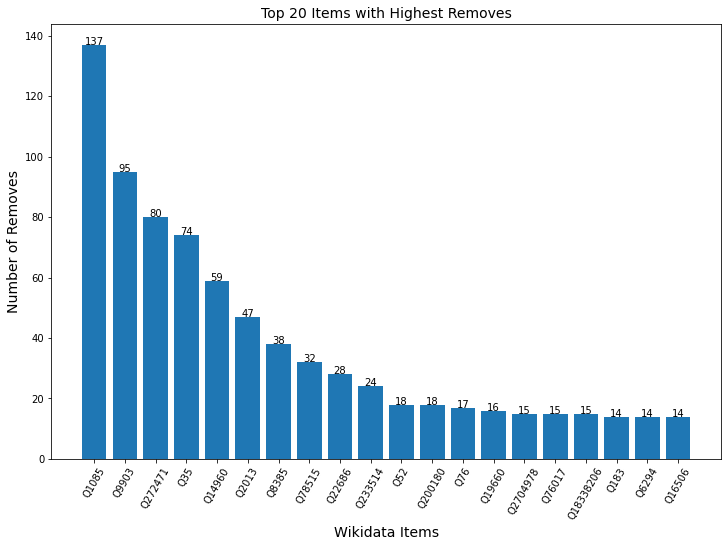

In [174]:
f, ax = plt.subplots(figsize=(12,8))

for i, r in enumerate(top20_removes['remove']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

plt.bar(top20_removes['qid'], top20_removes['remove'])
plt.xticks(rotation=60)
plt.xlabel("Wikidata Items", fontsize=14)
plt.ylabel("Number of Removes", fontsize=14)
plt.title("Top 20 Items with Highest Removes", fontsize=14)

In [167]:
top20_edits = proxies_without_remove.nlargest(20, 'editscount')

In [168]:
top20_edits

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
8408,Q1085,1,0,0,1,0,137,657,23
11055,Q22686,5,1,19,2,0,28,456,122
11423,Q28614,0,0,0,1,0,5,338,12
9104,Q7747,2,0,4,4,0,12,307,22
9724,Q14960,0,0,1,0,0,59,279,10
9328,Q9903,0,0,2,0,0,95,208,19
8972,Q6294,12,0,3,8,0,14,199,52
9130,Q8385,1,0,0,4,0,38,195,9
65506,Q15068349,0,0,1,0,0,3,192,89
9434,Q11256,5,1,16,0,0,7,164,51


In [169]:
edit_item_labels = ['Prague', 'Donald Trump', 'Garry Kasparov', 'Vladimir Putin', 'Brno',
                     'Ming dynasty', 'Hillary Clinton', 'Ostrava', 'Andrei Karlov', 'Fidel Castro', 
                     'Kingdom of Denmark', 'France', 'Russia', 'Georgia', 'Netherlands',  
                     'Spain', 'Denmark', 'Michigan', 'United States of America', 'Palana Village']

# Inserting item labels into restore proxies dataframe
top20_edits.insert(1, "label", edit_item_labels, True)

Text(0.5, 1.0, 'Top 20 Items with Highest Edits')

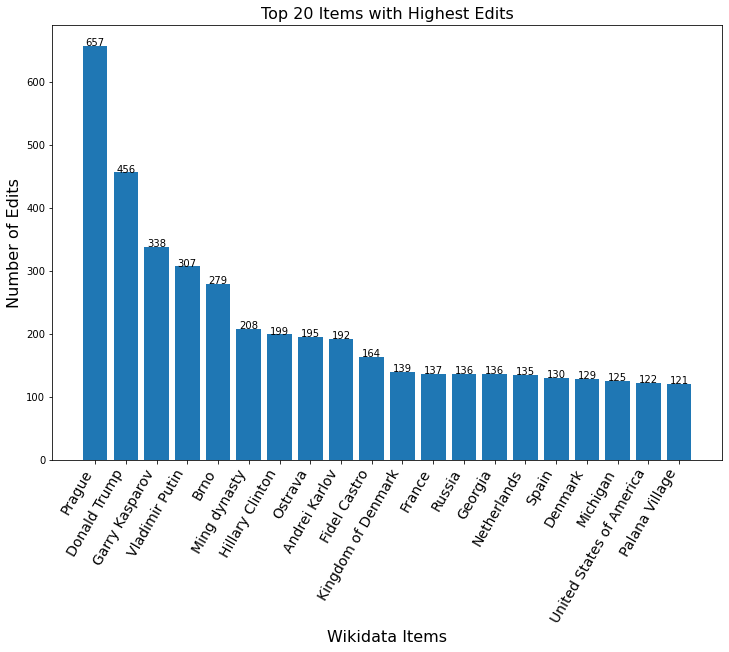

In [170]:
f, ax = plt.subplots(figsize=(12,8))

for i, r in enumerate(top20_edits['editscount']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

plt.bar(top20_edits['label'], top20_edits['editscount'])
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Edits", fontsize=16)
plt.title("Top 20 Items with Highest Edits", fontsize=16)

In [171]:
top20_users = proxies_without_remove.nlargest(20, 'userscount')

In [172]:
top20_users

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
11055,Q22686,5,1,19,2,0,28,456,122
65506,Q15068349,0,0,1,0,0,3,192,89
23366,Q548733,0,1,1,0,0,4,93,55
8972,Q6294,12,0,3,8,0,14,199,52
8081,Q30,1,1,6,4,1,5,122,51
9434,Q11256,5,1,16,0,0,7,164,51
12790,Q57311,4,0,3,1,0,5,100,44
8105,Q76,0,0,2,3,0,17,100,41
8127,Q183,0,0,5,0,0,14,115,40
11235,Q24313,1,0,0,0,0,1,56,39


In [173]:
user_item_labels = ['Donald Trump', 'Andrei Karlov', 'Vajiralongkorn I of Thailand', 'Hillary Clinton', 'United States of America',
                     'Fidel Castro', 'Juan Manuel Santos', 'Barack Obama', 'Germany', 'Mike Pence', 
                     'Steve Bannon', 'France', 'Paolo Gentiloni', 'Spain', 'Rex Tillerson ',  
                     'Netherlands', 'Denmark', 'Ivanka Trump', 'People\'s Republic of China', 'Japan']

# Inserting item labels into restore proxies dataframe
top20_users.insert(1, "label", user_item_labels, True)

Text(0.5, 1.0, 'Top 20 Items with Highest Users')

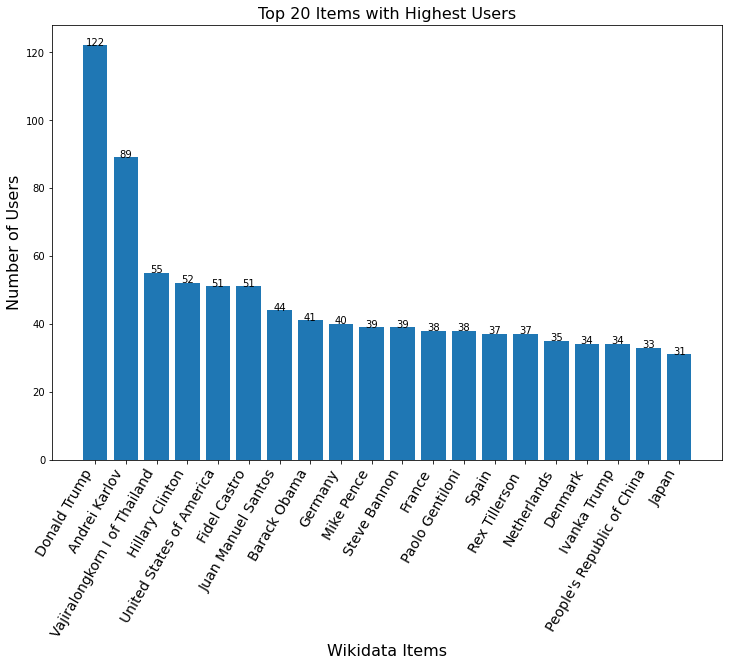

In [174]:
f, ax = plt.subplots(figsize=(12,8))

for i, r in enumerate(top20_users['userscount']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

plt.bar(top20_users['label'], top20_users['userscount'])
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Users", fontsize=16)
plt.title("Top 20 Items with Highest Users", fontsize=16)

In [188]:
# Finding most commonly occurring items in proxies revert, merge, restore and undo
# Ignoring protect and remove for now
# using edits and users due to assumptions made on controversial items

data_frames = [top20_reverts, top20_merges, top20_undos, top20_restores, top20_edits, top20_users]
common_items = pd.concat(data_frames)


In [214]:
common_items_count = common_items['qid'].value_counts()
common_20 = common_items_count.nlargest(20)
print(common_20)

Q29        5
Q30        4
Q6294      4
Q1001      3
Q22686     3
Q11256     3
Q7747      3
Q8385      2
Q183       2
Q35        2
Q15975     2
Q296741    2
Q96        2
Q182276    2
Q142       2
Q76        2
Q717       2
Q9061      2
Q517       2
Q55        2
Name: qid, dtype: int64
